In [1]:
import matplotlib.pyplot as plt
import scipy.signal
from pyedflib import highlevel

import pandas as pd
import numpy as np
import random

import ast
import os.path
import gc

from sklearn.model_selection import train_test_split
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import precision_score, \
    recall_score, confusion_matrix, classification_report, \
    accuracy_score, f1_score

from scipy.signal import butter, lfilter

In [2]:
signal_len = 750
make_filter = True

In [3]:
def normalize(Y):
    X = Y.copy()
    X -= X.mean()
    # X /= np.abs(X).max()
    return X

In [4]:
def bandpass(lowcut, highcut, order, fs):
    nyq = 0.5 * fs
    low = lowcut / nyq
    high = highcut / nyq
    b, a = butter(order, [low, high], btype='band')
    return b, a

def final_filter(data, fs, order=2):
    if make_filter:
        b, a = bandpass(0.1, 40, order, fs)
        x = lfilter(b, a, data)
        return x
    return data

In [5]:
path = "../Data"

amy_path = os.path.join(path, "Amy/Amy")
amyc_path = os.path.join(path, "AmyC/AmyC")
norm_path = os.path.join(path, "AMY_add/AMY/2")

amy = []
amyc = []
norm = []

#signals, signal_headers, header = highlevel.read_edf(os.path.join(amy_path, "Amy1.edf"), ch_names=['ECG I'])
# print(signal_headers)
# print(header)

for name in os.listdir(amy_path):
    signals, signal_headers, _ = highlevel.read_edf(os.path.join(amy_path, name), ch_names=['ECG I'])

    signal = signals[0]
    amy.append(final_filter(normalize(signal), signal_headers[0]["sample_frequency"]))  

for name in os.listdir(amyc_path):
    signals, signal_headers, _ = highlevel.read_edf(os.path.join(amyc_path, name), ch_names=['ECG I'])

    signal = signals[0]
    amyc.append(final_filter(normalize(signal), signal_headers[0]["sample_frequency"]))  

for name in os.listdir(norm_path):
    signals, signal_headers, _ = highlevel.read_edf(os.path.join(norm_path, name), ch_names=['ECG I'])

    signal = signals[0]
    norm.append(final_filter(normalize(signal), signal_headers[0]["sample_frequency"]))  

sample_rate = signal_headers[0]["sample_frequency"]

In [6]:
start = 1
end = 200
def extract_fft(X):
    Y = np.fft.rfft(X)
    return np.abs(Y[start:end])

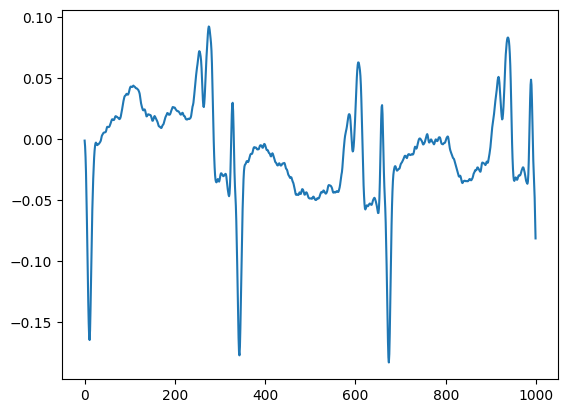

In [7]:
plt.plot(amyc[0][0:1000])

In [8]:
norm_parts = []
amy_parts = []
amyc_parts = []

for record in norm:
    for i in range(int(record.shape[0] / signal_len) - 1):
        norm_parts.append(np.array(normalize(record[i*signal_len:(i+1) * signal_len])))

for record in amy:
    for i in range(int(record.shape[0] / signal_len) - 1):
        amy_parts.append(np.array(normalize(record[i*signal_len:(i+1) * signal_len])))
        
for record in amyc:
    for i in range(int(record.shape[0] / signal_len) - 1):
        amyc_parts.append(np.array(normalize(record[i*signal_len:(i+1) * signal_len])))

In [9]:
print(len(norm_parts), "- Norm parts")
print(len(amy_parts), "- amy parts")
print(len(amyc_parts), "- amyc parts")

norm_parts = np.array(norm_parts)
amy_parts = np.array(amy_parts)
amyc_parts = np.array(amyc_parts)

510 - Norm parts
396 - amy parts
310 - amyc parts


In [10]:
data = np.concatenate([norm_parts, amy_parts])
lab = np.concatenate([np.zeros(len(norm_parts)), np.ones(len(amy_parts))])


# result = np.zeros((len(data), 4))
 
#columns = ['std', 'min', 'max', 'target']

# for i in range(result.shape[0]):
#         f = extract_statistical_features(data[i])
#         #normalize_spectrum(f)
#         f = np.append(f,lab[i])
#         result[i] = f

result = np.zeros((len(data), end - start +1))
columns = []
for i in range(start, end, 1):
    columns.append(str(i) + " HZ")
columns.append("target")

for i in range(result.shape[0]):
        f = extract_fft(data[i])
#         normalize_spectrum(f)
        f = np.append(f,lab[i])
        result[i] = f




#     # Теперь присоедините новую строку к датафрейму
#     FFT_df = pd.concat([FFT_df, new_row], ignore_index=True)
FFT_df = pd.DataFrame(columns=columns, data = result)
print(FFT_df.shape)
FFT_df.head()

(906, 200)


,1 HZ,2 HZ,3 HZ,4 HZ,5 HZ,6 HZ,7 HZ,8 HZ,9 HZ,10 HZ,...,191 HZ,192 HZ,193 HZ,194 HZ,195 HZ,196 HZ,197 HZ,198 HZ,199 HZ,target
0,10.852733,9.716253,9.654083,2.322228,2.640149,3.936529,5.325106,5.965424,1.801271,2.527614,...,0.003169,0.008039,0.003718,0.001485,0.004267,0.001385,0.002083,0.000816,0.004048,0.0
1,4.929100,4.420931,13.152315,7.445366,0.686019,5.146123,11.932736,9.314546,2.099734,3.039158,...,0.023278,0.032606,0.023882,0.029448,0.030438,0.027298,0.022404,0.024546,0.024096,0.0
2,5.231386,10.660741,7.077682,3.639739,1.781266,5.216434,5.700378,4.318342,2.712311,2.783804,...,0.030902,0.038301,0.031856,0.030813,0.038189,0.038620,0.034374,0.030145,0.034308,0.0
3,12.216785,4.529234,9.984261,5.073797,4.687692,2.921551,6.764199,7.316311,2.303742,1.247038,...,0.040029,0.042178,0.041978,0.042138,0.043259,0.040790,0.039945,0.037993,0.039281,0.0
4,13.137715,4.787502,10.314452,3.213372,4.936914,1.579915,7.804936,4.554149,2.810429,1.417536,...,0.044945,0.041372,0.045675,0.045093,0.042872,0.040151,0.037280,0.044234,0.040329,0.0



 clasification report:
               precision    recall  f1-score   support

         0.0       0.70      0.53      0.61       105
         1.0       0.52      0.69      0.59        77

    accuracy                           0.60       182
   macro avg       0.61      0.61      0.60       182
weighted avg       0.62      0.60      0.60       182

Матрица несоответствий для тестовой выборки метода ЛДА:



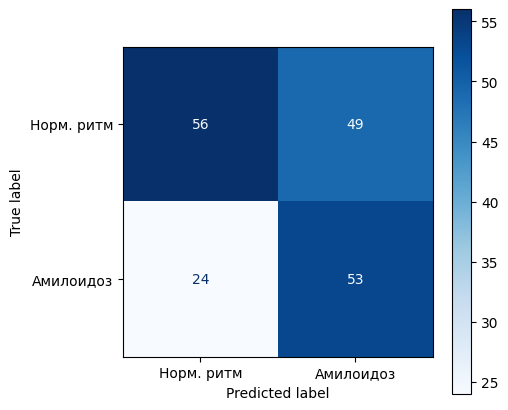

In [11]:
X = FFT_df.drop(columns=['target'])  # Убираем столбец с таргетом из признаков
y = FFT_df['target']

# Разделение данных на обучающий и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Создание и обучение модели ЛДА
lda_model = LinearDiscriminantAnalysis()
lda_model.fit(X_train, y_train)

# Предсказание на тестовом наборе
y_pred = lda_model.predict(X_test)

# Замените названия классов на соответствующие вам
class_names = ['Норм. ритм', 'Амилоидоз']

print ('\n clasification report:\n', classification_report(y_test, y_pred))

print('Матрица несоответствий для тестовой выборки метода ЛДА:\n')
fig, ax = plt.subplots(figsize=(5, 5))
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred), display_labels= class_names)
disp.plot(cmap = 'Blues', ax=ax);

In [12]:
from sklearn.base import BaseEstimator, TransformerMixin

class CustomPreprocessor(BaseEstimator, TransformerMixin):
    def __init__(self, start=1, end=200, lowcut = 0.01, highcut=100, order = 6):
        # Параметры предобработки
        self.start = start
        self.end = end
        self.lowcut = lowcut
        self.highcut = highcut
        self.order = order

    def highpass(self, highcut, order, fs):
        nyq = 0.5 * fs
        high = highcut / nyq
        b, a = butter(order, high, btype='high')
        return b, a
    
    def bandpass(self, lowcut, highcut, order, fs):
        nyq = 0.5 * fs
        low = lowcut / nyq
        high = highcut / nyq
        b, a = butter(order, [low, high], btype='band')
        return b, a

    def final_filter(self, data, fs, order=2):
        if make_filter:
            # b, a = bandpass(self.lowcut, self.highcut, order, fs)
            b, a = self.highpass(self.highcut, order, fs)
            x = lfilter(b, a, data)
            return x
        return data
    
    def extract_fft(self, X):
        Y = np.fft.rfft(X)
        return np.abs(Y[self.start:self.end])

    def fit(self, X, y=None):
        # Если нужна подгонка (например, расчет среднего, если требуется)
        # В данном случае ничего не делаем, но сохраняем интерфейс
        return self

    def transform(self, X):
        # Основная логика предобработки данных
        # Например, если param1=True, применить одну операцию, если False — другую
        result = np.zeros((len(X), self.end - self.start))

        for i in range(result.shape[0]):
                f = self.extract_fft(self.final_filter(X[i], 500))
        #         normalize_spectrum(f)
                result[i] = f
        return result

    def fit_transform(self, X, y=None):
        # Можно реализовать fit и transform одновременно для эффективности
        return self.fit(X, y).transform(X)



In [31]:
# Определение пайплайна
pipeline = Pipeline([
    ('preproc', CustomPreprocessor()),  # Пример предобработки данных (масштабирование)
    ('lda', LinearDiscriminantAnalysis())  # Модель LDA
])

# Определение сетки гиперпараметров для GridSearch
param_grid = {
    # 'preproc__start' : [2 * i for i in range(25)],
    # 'end' : [i for i in range(10, 70)],
    # 'lowpass' : [0.1 * i for i in range(50)],
    # 'highpass' : [i for i in range(20, 70)]
    'preproc__start' : [i for i in range(0, 20, 2)],
    'preproc__end' : [i for i in range(30, 80, 5)],
    #'preproc__lowcut' : [0.1 * i for i in range(2)],
    'preproc__highcut' : [i for i in range(10, 70, 2)],
    'preproc__order' : [4, 6]
}

# Настройка GridSearchCV
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='f1')

data = np.concatenate([norm_parts, amy_parts])
lab = np.concatenate([np.zeros(len(norm_parts)), np.ones(len(amy_parts))])

# Обучение модели с подбором гиперпараметров
grid_search.fit(data, lab)

# Результаты
print("Лучшие параметры: ", grid_search.best_params_)
print("Лучшая точность: ", grid_search.best_score_)

Лучшие параметры:  {'preproc__end': 35, 'preproc__highcut': 56, 'preproc__order': 4, 'preproc__start': 2}
Лучшая точность:  0.5756982585036884


# Выше результаты нового поиска
## Ниже взял прошлые результаты, там точность выше

In [17]:

cprep = CustomPreprocessor(start=0, end=30, lowcut=0, highcut=56, order=4) 

processed_data = cprep.transform(data)

processed_data = pd.DataFrame(processed_data)



,0,1,2,3,4,5,6,7,8,9,...,20,21,22,23,24,25,26,27,28,29
0,0.001430,0.001261,0.006612,0.010599,0.003720,0.006436,0.021014,0.031224,0.052618,0.020089,...,0.158353,0.142934,0.177385,0.176956,0.191059,0.225286,0.237662,0.207252,0.217544,0.210430
1,0.012771,0.012905,0.013152,0.014797,0.016847,0.015053,0.021059,0.073283,0.073554,0.012841,...,0.052487,0.202495,0.337068,0.235477,0.037316,0.317672,0.403253,0.161235,0.198596,0.435777
2,0.000839,0.001329,0.004834,0.009299,0.006698,0.005594,0.023812,0.037930,0.034277,0.030229,...,0.149170,0.150188,0.164654,0.182436,0.187945,0.196618,0.187656,0.183539,0.184626,0.211574
3,0.042097,0.043699,0.040788,0.047039,0.052968,0.055973,0.045102,0.064734,0.104336,0.066408,...,0.252086,0.098425,0.146141,0.322133,0.307460,0.106727,0.243391,0.421396,0.316961,0.045966
4,0.000613,0.001068,0.002675,0.012907,0.007654,0.016283,0.007802,0.049407,0.036769,0.030154,...,0.134185,0.154353,0.169228,0.164344,0.169951,0.197816,0.217475,0.182693,0.203498,0.191765



 clasification report:
               precision    recall  f1-score   support

         0.0       0.69      0.62      0.65       105
         1.0       0.55      0.62      0.58        77

    accuracy                           0.62       182
   macro avg       0.62      0.62      0.62       182
weighted avg       0.63      0.62      0.62       182

Матрица несоответствий для тестовой выборки метода ЛДА:



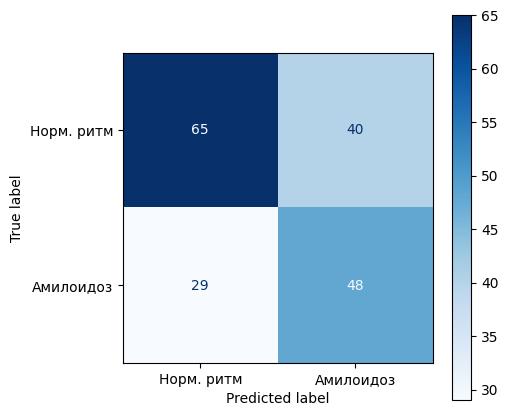

In [18]:
X = processed_data
y = lab

# Разделение данных на обучающий и тестовый наборы
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Создание и обучение модели ЛДА
lda_model = LinearDiscriminantAnalysis()
lda_model.fit(X_train, y_train)

# Предсказание на тестовом наборе
y_pred = lda_model.predict(X_test)

# Замените названия классов на соответствующие вам
class_names = ['Норм. ритм', 'Амилоидоз']

print ('\n clasification report:\n', classification_report(y_test, y_pred))

print('Матрица несоответствий для тестовой выборки метода ЛДА:\n')
fig, ax = plt.subplots(figsize=(5, 5))
disp = ConfusionMatrixDisplay(confusion_matrix(y_test, y_pred), display_labels= class_names)
disp.plot(cmap = 'Blues', ax=ax);

In [31]:
def calcGroupTable(groupnames : list, records : list, df : pd.DataFrame):
    for i in range(len(groupnames)):
        record = records[i]
        parts = []
        for m in range(int(record.shape[0] / signal_len) - 1):
            parts.append(np.array(normalize(record[m*signal_len:(m+1) * signal_len])))
        transformed = cprep.transform(parts)
        y_pred = lda_model.predict(transformed)
        y_weighted = np.asarray(y_pred).sum() / len(y_pred)

        y_weighted = round(y_weighted)

        df.loc[-1] = [groupnames[i], y_weighted]
        df.index = df.index + 1
        df = df.sort_index()
    return df

In [41]:
# There are two classes. 0 - norm, 1 - amy

pred_tab = pd.DataFrame(columns=["name", "weighted_predict"])

norm_names = os.listdir(norm_path)
amy_names = os.listdir(amy_path)

norm_names = [name[:6] + "_norm" + name[6:] for name in norm_names]

pred_tab = calcGroupTable(norm_names, norm, pred_tab)
pred_tab = calcGroupTable(amy_names, amy, pred_tab)


pred_tab.head(5)

pred_tab.to_csv("lda_result.csv")
    